In [1]:
import sys
import cython
import numpy as np
import scipy.sparse as sps

sys.path.append('../RecSysRep/')

In [2]:
import Basics.Load as ld
URM_all, ICM_genre_all, ICM_subgenre_all, ICM_channel_all, ICM_event_all = ld.getCOOs()

In [3]:
import os
output_folder_path = "../result_experiments/SLIM_KNN_sim/"

In [4]:
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
        
n_cases = 50  # using 10 as an example
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

In [5]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)

In [6]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions


In [7]:
# We obtain the Similarity Matrix of the best models
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender1 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
recommender2 = ItemKNNCBFRecommender(URM_train, ICM_genre_all)

ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.


In [8]:
# We fit the models with best hyperparameters found
hyp_best_1 = {'topK': 1203, 'l1_ratio': 0.0007860291403064104, 'alpha': 0.07969416051151235, 'workers': 8}
hyp_best_2 = {"shrink": 1642, "topK": 734, "feature_weighting": "TF-IDF", "normalize": True}

recommender1.fit(**hyp_best_1)
recommender2.fit(**hyp_best_2)

100%|███████████████████████████████████████████████████████████████████████████▉| 18032/18059 [14:45<00:00, 32.21it/s]

Similarity column 18059 (100.0%), 7829.71 column/sec. Elapsed time 2.31 sec


In [9]:
'''
recommender1.save_model(output_folder_path, 
                              file_name = recommender_object.RECOMMENDER_NAME + "_heatmap.zip" )
recommender2.save_model(output_folder_path, 
                              file_name = recommender_object.RECOMMENDER_NAME + "_heatmap.zip" )
'''

'\nrecommender1.save_model(output_folder_path, \n                              file_name = recommender_object.RECOMMENDER_NAME + "_heatmap.zip" )\nrecommender2.save_model(output_folder_path, \n                              file_name = recommender_object.RECOMMENDER_NAME + "_heatmap.zip" )\n'

In [10]:
'''
recommender1.load_model(output_folder_path, file_name = recommender1.RECOMMENDER_NAME + "_heatmap.zip")

recommender2.load_model(output_folder_path, file_name = recommender2.RECOMMENDER_NAME + "_heatmap.zip")
'''

'\nrecommender1.load_model(output_folder_path, file_name = recommender1.RECOMMENDER_NAME + "_heatmap.zip")\n\nrecommender2.load_model(output_folder_path, file_name = recommender2.RECOMMENDER_NAME + "_heatmap.zip")\n'

100%|███████████████████████████████████████████████████████████████████████████▉| 18056/18059 [14:51<00:00, 20.24it/s]


0.031272236
0.006843301
0.031272236
0.0


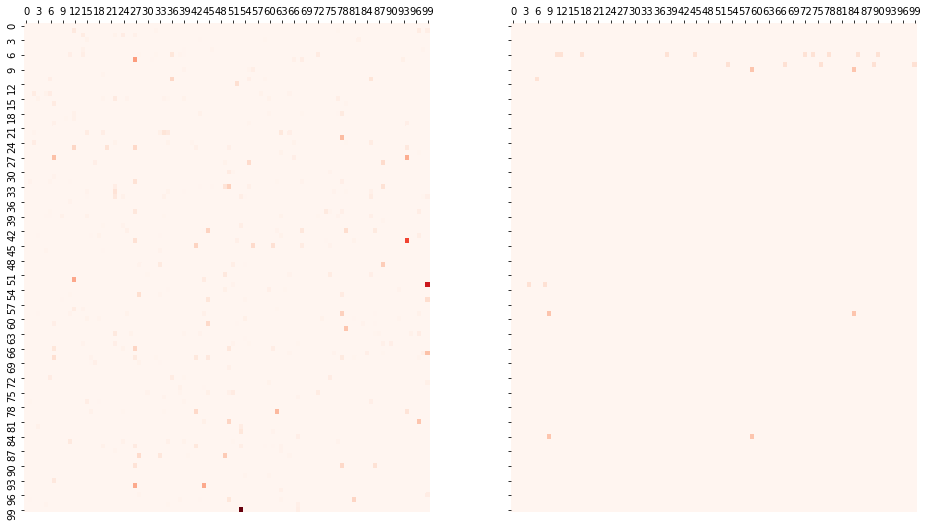

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

size = 100

# We then draw the heatmaps
slim_sim = recommender1.W_sparse
knn_sim = recommender2.W_sparse

slim_sim_max = slim_sim[:size,:size].max()
knn_sim_max = knn_sim[:size,:size].max()
vmax = np.max([slim_sim_max, knn_sim_max])
print(slim_sim_max)
print(knn_sim_max)
print(vmax)
print(slim_sim.min())

f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
sns.heatmap(slim_sim[:size,:size].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds")
sns.heatmap(knn_sim[:size,:size].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2, cmap="Reds")
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")

In [12]:
print(np.unravel_index(np.argmax(slim_sim), slim_sim.shape))

(7088, 14673)


In [18]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

alpha = 0.6

new_similarity = slim_sim * alpha + knn_sim * (1-alpha)

recommender_object = ItemKNNCustomSimilarityRecommender(URM_train)
recommender_object.fit(new_similarity)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

EvaluatorHoldout: Processed 13645 (100.0%) in 24.21 sec. Users per second: 564


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.393082,0.395155,0.070812,0.241259,0.242244,0.643044,0.407418,0.120005,0.975595,1.224459,...,0.047843,0.999634,0.975238,0.009846,7.734333,0.991227,0.03971,0.624242,2.649586,0.026021
